In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from __future__ import division

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Conv2D
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling2D

import tensorflow as tf
import tensorflow_hub as hub
import logging

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

logging.basicConfig(level=logging.INFO)

**Load Data**

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_clean_df = pd.read_excel("../data/full_clean_df.xlsx", index_col=0)

In [ ]:
labels_name_list = ['NotHate', 'Racist', 'Sexist', 'Homophobe', 'Religion', 'OtherHate']

In [ ]:
# max length of tweet
max([len(i) for i in full_clean_df['tweets_train'].apply(lambda x: x.split(' '))])

24

**Split Data**

In [ ]:
X, X_test, y, y_test =  train_test_split(full_clean_df['tweets_train'], full_clean_df[labels_name_list], test_size=0.33, random_state=12)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=12)

In [ ]:
X_train.shape

(64316,)

Define function to plot history

In [ ]:
def plot_history(history):
    # Plot loss and AUC 
    fig = plt.figure(figsize=(10,5))

    #plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['val_loss'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['loss'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #plt.subplot(1, 2, 2)
    fig = plt.figure(figsize=(10,5))
    plt.plot(history.epoch, history.history['val_auc'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['auc'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('AUC on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
vect = Tokenizer()
vect.fit_on_texts(X_train)
vocab_size = len(vect.word_index) + 1

In [ ]:
vocab_size

31646

In [ ]:
train_encoded = vect.texts_to_sequences(X_train)
max_length = vocab_size
train_padded = pad_sequences(train_encoded, maxlen=30, padding='post')
print(train_padded)

[[ 3106   513    38 ...     0     0     0]
 [   19     1 14057 ...     0     0     0]
 [  142 14058    37 ...     0     0     0]
 ...
 [  112   114   647 ...     0     0     0]
 [  263     7    17 ...     0     0     0]
 [ 1306     5     7 ...     0     0     0]]


In [ ]:
val_encoded = vect.texts_to_sequences(X_val)
test_encoded = vect.texts_to_sequences(X_test)

val_padded = pad_sequences(val_encoded, maxlen=30, padding='post')
test_padded = pad_sequences(test_encoded, maxlen=30, padding='post')

**CNN**

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, input_length=30))
# CNN Model
model.add(Conv1D(filters=64,
                  kernel_size=3,
                  padding='valid',
                  activation='relu',
                  strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           3164600   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            19264     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 3,184,254
Trainable params: 3,184,254
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision', 'Recall', 'AUC'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(train_padded, y_train, epochs=5, validation_data=(val_padded, y_val), batch_size=256, callbacks=[es])

Epoch 1/5
252/252 [==============================] - 43s 47ms/step - loss: 0.4244 - precision: 0.8066 - recall: 0.5894 - auc: 0.8396 - val_loss: 0.2746 - val_precision: 0.8763 - val_recall: 0.6748 - val_auc: 0.9314
Epoch 2/5
252/252 [==============================] - 11s 43ms/step - loss: 0.2651 - precision: 0.8667 - recall: 0.6995 - auc: 0.9365 - val_loss: 0.2657 - val_precision: 0.8647 - val_recall: 0.6969 - val_auc: 0.9357
Epoch 3/5
252/252 [==============================] - 11s 43ms/step - loss: 0.2422 - precision: 0.8692 - recall: 0.7474 - auc: 0.9479 - val_loss: 0.2710 - val_precision: 0.8348 - val_recall: 0.7171 - val_auc: 0.9342
Epoch 00003: early stopping


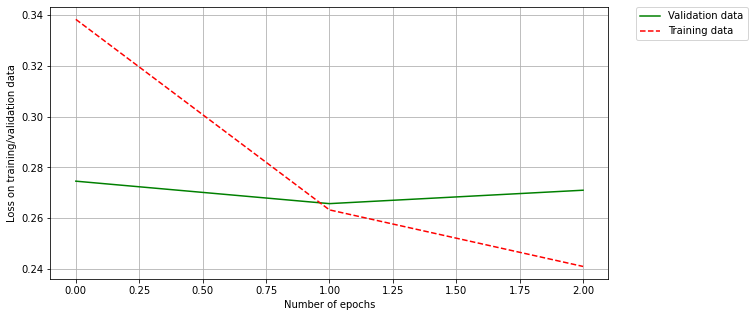

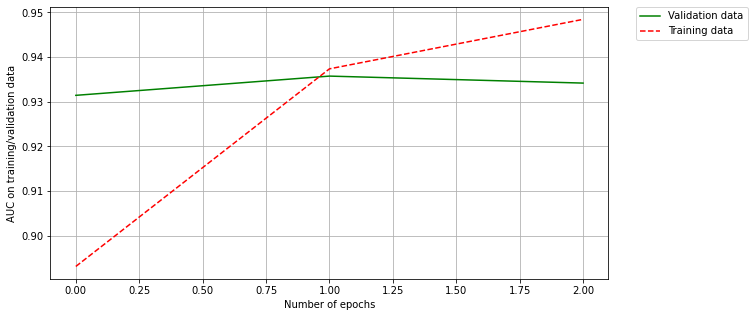

In [ ]:
plot_history(history)

In [ ]:
predictions = model.predict(val_padded)

In [ ]:
# function to find the best threshold 

def optimal_threshold(test, predictions):
  thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  
  threshold_df = pd.DataFrame({})
  
  for thres in thresholds:
      pred = predictions.copy()
    
      pred[pred >= thres] = 1
      pred[pred < thres] = 0
    
      precision = precision_score(test, pred, average='macro')
      recall = recall_score(test, pred, average='macro')
      f1 = f1_score(test, pred, average='macro')

      df = pd.DataFrame({
          'threshold': round(thres, 4),
          'prediction': round(precision, 4),
          'recall': round(recall, 4),
          'f1': round(f1, 4)
      }, index=[0])

      threshold_df = threshold_df.append(df)
  return threshold_df.reset_index(drop=True)

In [ ]:
optimal_threshold(y_val, predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,prediction,recall,f1
0,0.1,0.5327,0.6978,0.5228
1,0.2,0.5862,0.6269,0.5412
2,0.3,0.5151,0.5634,0.5332
3,0.4,0.5450,0.4941,0.5122
4,0.5,0.5789,0.4184,0.4728
5,0.6,0.6205,0.3562,0.4249
6,0.7,0.6594,0.3000,0.3696
7,0.8,0.6960,0.2335,0.2911
8,0.9,0.7428,0.1540,0.1816


In [ ]:
# optimized threshold = 0.2 

cnn_pred = [[1 if i >=0.2 else 0 for i in pred] for pred in predictions]
print(metrics.classification_report(y_val, cnn_pred, digits=6))

              precision    recall  f1-score   support

           0   0.923269  0.998756  0.959530     28950
           1   0.432800  0.851784  0.573963      9837
           2   0.475099  0.577047  0.521134      4348
           3   0.670833  0.674204  0.672515      2388
           4   0.600000  0.006410  0.012685       468
           5   0.415213  0.653087  0.507667      4664

   micro avg   0.676738  0.877722  0.764237     50655
   macro avg   0.586202  0.626882  0.541249     50655
weighted avg   0.727887  0.877722  0.783141     50655
 samples avg   0.704078  0.909451  0.763383     50655



In [ ]:
print(metrics.multilabel_confusion_matrix(y_val, cnn_pred))

[[[  326  2403]
  [   36 28914]]

 [[10861 10981]
  [ 1458  8379]]

 [[24559  2772]
  [ 1839  2509]]

 [[28501   790]
  [  778  1610]]

 [[31209     2]
  [  465     3]]

 [[22725  4290]
  [ 1618  3046]]]
